In [1]:
import sys, argparse, os, glob
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from pytorch_lightning.loggers import WandbLogger
sys.path.insert(0, '../')
from pytorch_lightning import Trainer
from dataProcessing.dataModule import SingleDatasetModule
from models.pseudoLabSelection import getPseudoLabel
from trainers.trainerClf import ClfModel
from trainers.trainerTL import TLmodel
from Utils.myUtils import  MCI,getTeacherParams,getPLS_params

In [5]:
inPath = 'C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\frankDataset\\originalWindFreq\\'
params_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\experiments\\params\\V5\\'
save_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\saved\\teacherOficialV5\\'


datasetList = ['Dsads','Ucihar','Uschad','Pamap2']
n_classes = 4 
source = 'Uschad'
target = 'Ucihar'
model = "V5"
paramsPath = os.path.join(params_path, "Disc" + source[:3] + target[:3] + ".json")
teacherParams = getTeacherParams(paramsPath)


In [8]:

dm_target = SingleDatasetModule(data_dir=inPath,
                                datasetName="",
                                input_shape=2,
                                n_classes=4,
                                batch_size=128,
                                oneHotLabel = False,
                                shuffle=True)
dm_target.setup(normalize=False, fileName=f"{target}AllOriginal_target_{source}AllOriginal.npz")
teacherParams['input_shape'] = dm_target.dataTrain.X.shape[1:]
model = TLmodel(trainParams=teacherParams,
                n_classes=4,
                lossParams=None,
                save_path=None,
                class_weight=None)

model.setDatasets(dm_target = dm_target)
model.create_model()
model.load_params(save_path, f'Teacher{model}_{source}AllOriginal_{target}AllOriginal')
predT = model.getPredict(domain='Target')
pred = {}
pred['latent'] = predT['latentTarget']
pred['pred']   = predT['predTarget']
pred['true']   = predT['trueTarget']
pred['probs']  = predT['probTarget']
pred['data']   = predT['dataTarget']


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\saved\\teacherOficialV5\\TeacherTLmodel(\n  (FE): Encoder(\n    (CNN1): ModuleList(\n      (0): Sequential(\n        (0): Conv2d(2, 8, kernel_size=(5, 3), stride=(1, 1), padding=same, groups=2)\n        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n        (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)\n        (3): LeakyReLU(negative_slope=0.01)\n      )\n      (1): Sequential(\n        (0): Conv2d(2, 16, kernel_size=(25, 3), stride=(1, 1), padding=same, groups=2)\n        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n        (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)\n        (3): LeakyReLU(negative_slope=0.01)\n      )\n    )\n    (DenseLayer): Sequential(\n      (0): Conv2d(24, 26, kernel_size=(5, 3), stride=(1, 1), padding=same)\n      (1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (2): LeakyReLU(negative_slope=0.01)\n      (3): MaxPool2d(kernel_size=(5, 1), stride=(5, 1), padding=0, dilation=1, ceil_mode=False)\n      (4): Flatten(start_dim=1, end_dim=-1)\n      (5): Linear(in_features=1300, out_features=128, bias=True)\n      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    )\n  )\n  (Disc): discriminator(\n    (layer): Sequential(\n      (0): Linear(in_features=128, out_features=64, bias=True)\n      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (2): LeakyReLU(negative_slope=0.01)\n      (3): Dropout(p=0.2, inplace=False)\n      (4): Linear(in_features=64, out_features=4, bias=True)\n      (5): Softmax(dim=1)\n    )\n  )\n  (clfLoss): CrossEntropyLoss()\n  (classDist): CenterLoss()\n  (discLoss): OTLoss(\n    (lossFunc): SamplesLoss()\n  )\n)_UschadAllOriginal_UciharAllOriginal_feature_extractor'

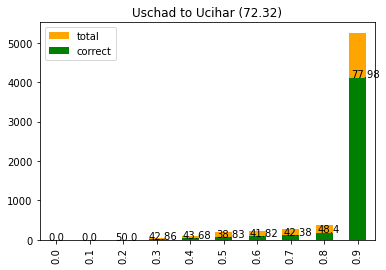

In [15]:
def plotAcuracyPerConfidenceLevel(true,predictions,probs):
    accIni = accuracy_score(true, predictions)
    accIni = round(100*accIni,2)
    f1Ini = f1_score(true, predictions,average = 'weighted')
    cm = confusion_matrix(true,predictions)
    #probs = probs.max(axis = 1)
    correct = []
    total = []
    x = []
    accList = []
    for i in range(0,10):
        a = np.where(probs>i/10)[0]
        b = np.where(probs<i/10 + 0.1)[0]
        x.append(i/10)
        idx = np.intersect1d(a, b)
        if len(idx)>0:
            acc = accuracy_score(true[idx],predictions[idx])
            correct.append(acc*len(idx))
            total.append(len(idx)*1.0)
            accList.append(round(100*acc,2))
        else:
            correct.append(0.0)
            total.append(0.0)
            accList.append(0.0)
    df = pd.DataFrame(total,columns = ['total'],index = x)
    ax = plt.axes()
    df.plot(kind = 'bar',stacked=True,title = f'{source} to {target} ({accIni})',ax = ax,color = 'orange')
    df = pd.DataFrame(correct,columns = ['correct'],index = x)
    df.plot(kind = 'bar',stacked=True,ax = ax,color = 'green')
    i = 0
    for p in ax.patches:
        if i>9:
            ax.annotate(str(accList[i-10]), (p.get_x() * 1.005, p.get_height() * 1.005))
        i = i+1


### GMM confidence analize

In [ ]:
selectionParamList  = getPLS_params()
params = selectionParamList[0]
softLabelIdx = []
softLabelGenerated = []
X = []
Ytrue = []
selectedIdx = []
if params['nClusters'] > len(latent):
    return X, softLabelGenerated, Ytrue, selectedIdx

gm = GaussianMixture(n_components=params['nClusters'], random_state=0).fit(latent)
softLabel = np.argmax(probs, axis=1)
GMMprobs = gm.predict_proba(latent)  # (n_samples, n_components)
GMMprobs = np.max(GMMprobs, axis=1)

plotAcuracyPerConfidenceLevel(pred['true',pred['pred'],GMMprobs):

20

In [25]:
df

,correct,total
0.0,0.0,0
0.1,0.0,0
0.2,0.0,0
0.3,9.0,22
0.4,30.0,83
0.5,95.0,257
0.6,92.0,250
0.7,137.0,330
0.8,229.0,497
0.9,3730.0,5321
